In [ ]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [ ]:
# train feature set
train_feat = pd.read_csv('train_feat.csv')

In [ ]:
# convert classes to int
train_feat['Type'] = train_feat['Type'].map({'O': 0, 'N': 1, 'A': 2, '~': 3}).astype(int)

In [ ]:
# get just values and labels, and delete rows with nulls
train_feat.dropna(inplace=True)
print(train_feat.isnull().any().any())
X = train_feat.iloc[:,2:]
y = train_feat.iloc[:,1]

False


In [ ]:
# unbalanced classes
y.value_counts()

1    7719
0    3853
2    1160
3     322
Name: Type, dtype: int64

In [ ]:
# upsampling - NOT USED IN FINAL MODEL
# from imblearn.over_sampling import SMOTE
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)
# y.value_counts()

In [ ]:
# Scale and centre data before PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_standardised = scaler.fit_transform(X.values)

In [ ]:
# fit pca model with 99% variance coverage
pca = PCA(.99)
pca.fit(X_standardised)

0.9901307873897868


In [ ]:
# PCA transform the data for
X_reduced = pca.transform(X_standardised)

In [ ]:
from sklearn.model_selection import train_test_split
# split the data to train and test sets, stratify is important for unbalanced classes
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = 21, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10443, 126) (10443,)
(2611, 126) (2611,)


In [ ]:
# STANDARDISED, PCA DATA FED TO MODEL
# search space
parameters = {
    'n_estimators': sp_randInt(20,500),
    'criterion': ['gini', 'entropy'],
    'max_depth': sp_randInt(5,100),
    'max_features' : ['auto', 'sqrt'],
    'bootstrap' : [True, False]
}
#initiate classifier with random state for reproducability
rf_clf = RandomForestClassifier(random_state=2022)

# perform parameter tuning with f1_weighted scoring for multiclass averaging.
grid = RandomizedSearchCV(rf_clf, param_distributions=parameters, scoring='f1_weighted', cv=3, n_iter = 25, n_jobs=-1, verbose=4)
grid.fit(X_train, y_train)

print("The best Random Forest parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
The best Random Forest parameters are {'bootstrap': False, 'criterion': 'gini', 'max_depth': 71, 'max_features': 'auto', 'n_estimators': 445} with a score of 0.89


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.72      0.65      0.68       771
           1       0.83      0.94      0.88      1544
           2       0.88      0.66      0.75       232
           3       0.91      0.16      0.27        64

    accuracy                           0.81      2611
   macro avg       0.84      0.60      0.65      2611
weighted avg       0.81      0.81      0.80      2611



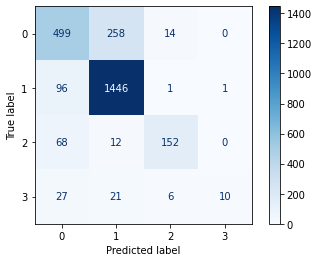

In [ ]:
# make RF classifier with ideal parameters
rf_model = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=71, max_features='sqrt', n_estimators=445, random_state=21)
rf_model.fit(X_train, y_train)

y_test_pred = rf_model.predict(X_test)

# Check the confusion matrix
disp = plot_confusion_matrix(rf_model, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)

# Just get a classification report.
print(classification_report(y_test, y_test_pred))

In [ ]:
#adaboost
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(random_state=2022)
parameters = {
    'n_estimators': sp_randInt(20,500),
    'learning_rate': sp_randFloat(0.1,2),
    'base_estimator': rf_model
}
ada_grid = RandomizedSearchCV(ada_clf, param_distributions=parameters, scoring='f1_weighted', cv=2, n_iter = 5, n_jobs=-1, verbose=4)
ada_grid.fit(X_train, y_train)

print("The best adaBoost parameters are %s with a score of %0.2f"
      % (ada_grid.best_params_, ada_grid.best_score_))

Fitting 2 folds for each of 5 candidates, totalling 10 fits
The best adaBoost parameters are {'base_estimator': DecisionTreeClassifier(max_depth=93, max_features='auto',
                       random_state=978338550), 'learning_rate': 2.0746774442304896, 'n_estimators': 177} with a score of 0.69


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0       0.73      0.65      0.69       771
           1       0.84      0.94      0.89      1544
           2       0.87      0.66      0.75       232
           3       0.85      0.17      0.29        64

    accuracy                           0.81      2611
   macro avg       0.82      0.60      0.65      2611
weighted avg       0.81      0.81      0.80      2611



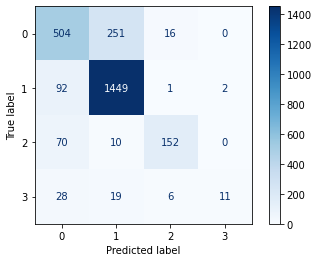

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_model3 = AdaBoostClassifier(base_estimator=rf_model, learning_rate=1.06, n_estimators=344, random_state=2022)
ada_model3.fit(X_train, y_train)

y_test_pred = ada_model3.predict(X_test)

# Check the confusion matrix
disp = plot_confusion_matrix(ada_model3, X_test, y_test,
                                 display_labels=None,
                                 cmap=plt.cm.Blues)

# Just get a classification report.
print(classification_report(y_test, y_test_pred))

In [ ]:
test_set = pd.read_csv('test_feat.csv')
test_feat = test_set.iloc[:,1:]
# have to fill not remove otherwise misses out last prediction
test_feat.fillna(0, inplace=True)
test_feat

,F0,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F178,F179,F180,F181,F182,F183,F184,F185,F186,F187
0,-10,10,0,0,0,0,0.035030,0.025541,0.026757,0.014211,...,0.260381,5.692895,0.780536,0,0,52.173913,0,53.428317,59.055118,1.168
1,-1,1,0,0,0,0,0.065561,0.052112,0.070092,0.020467,...,0.153337,22.404452,3.854612,0,0,48.154093,0,0.000000,56.818182,1.304
2,-25,25,0,0,0,0,0.004268,0.007249,0.008490,0.003402,...,0.003731,11.355926,2.649366,7,0,83.333333,0,84.447572,87.209302,0.744
3,16,0,16,0,1,10,0.091563,0.152688,0.194351,0.054590,...,0.026470,22.279271,-4.135135,3,0,66.371681,0,71.471114,89.285714,0.944
4,-34,34,0,0,0,0,0.032833,0.007840,0.009507,0.004046,...,0.268580,6.582272,0.501846,0,0,106.761566,0,115.273775,120.967742,0.576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,34,0,34,0,1,12,0.257070,0.382671,0.401493,0.205716,...,0.014037,13.499831,3.057967,5,0,103.448276,8,133.928571,178.571429,0.704
3996,-4,8,4,0,0,3,0.130805,0.205248,0.163456,0.130662,...,0.146989,18.188955,-2.744242,0,0,55.970149,0,59.347181,125.000000,1.184
3997,27,0,27,0,3,13,0.502131,0.786888,0.884271,0.382576,...,0.056684,3.645347,0.011702,28,0,90.090090,20,146.699266,202.702703,0.944
3998,-1,2,1,0,0,1,0.033182,0.035032,0.044967,0.013029,...,0.159070,9.421713,-0.581112,0,0,69.124424,0,71.985603,76.530612,0.888


In [ ]:
test_standardised = scaler.fit_transform(test_feat.values)
test_feat_reduced = pca.transform(test_standardised)

In [ ]:
test_pred = rf_model.predict(test_feat_reduced)
test_pred_classes = pd.DataFrame(test_pred)
print(test_pred_classes)

      0
0     1
1     1
2     0
3     1
4     0
...  ..
3995  2
3996  0
3997  3
3998  1
3999  1

[4000 rows x 1 columns]


In [ ]:
# GET PREDICTIONS AND IDS IN ONE DATAFRAME
test_pred_classes = test_pred_classes[0].map({0: 'O', 1: 'N', 2: 'A', 3: '~'}).astype(str)
test_pred_classes
test_id = test_set.iloc[:,0]
test_id

0       C00000
1       C00001
2       C00002
3       C00003
4       C00004
         ...  
3995    C03995
3996    C03996
3997    C03997
3998    C03998
3999    C03999
Name: ID, Length: 4000, dtype: object

In [ ]:
predictions = pd.concat([test_id, test_pred_classes], axis=1)
predictions

,ID,0
0,C00000,N
1,C00001,N
2,C00002,O
3,C00003,N
4,C00004,O
...,...,...
3995,C03995,A
3996,C03996,O
3997,C03997,~
3998,C03998,N


In [ ]:
predictions.to_csv('RF_Unbalanced_predictions.csv')

In [ ]:
print(test_set.shape)
print(test_feat.shape)
print(test_feat_reduced.shape)
print(predictions.shape)

(4000, 189)
(4000, 188)
(4000, 123)
(4000, 2)
